# It's time to get emotional!

The title may already give the vibe of what I'll try to achieve on this section: let's conduct a emotion detection analysis on raw texts of One Piece!

The idea here is to try grasping at the general "emotion" (relief, sadness, happiness...) of a given group of tokens. We could conduct this analysis at a word level, but it's not a good idea, here is a good example of why:

"I'm very happy" -> happiness

"I'm not happy" -> sadness

Breaking that string on a word level, we are opening for some inconsistencies, as the whole sentence has to be taken into consideration.

A good thing here is that when I developed the whole system for grouping transcriptions, I knew I had to break it all down to a common token to know when a sentence would end. On this case, all sentences end with "."!

*Quick disclaimer: even though I did it this way, spacy has a handy way of detecting when phrases start and end!*

**Another huge disclaimer: I began writing this section as "SENTIMENTAL", but sentiment analysis is not really a good application here as all my transcripts are based on the same principle of a story being told and I'd have to deal with heavy inconsistencies and a lot of bias. Because of this, I decided to change the topic to "emotion" detection on the sentence level. This way, I may consider the general "sentiment" of every phrase used on each given group.**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from collections import Counter

from transformers import pipeline

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)


def classify_emotions(texts: list[str], threshold=0.3) -> Counter:
    """
    Returns a Counter object with all emotions detected across a batch of sentences.

    Parameters:
        texts (list): List of text strings.
        threshold (float): Minimum score to consider an emotion as detected.

    Returns:
        Counter: Aggregated count of detected emotions across all texts.
    """
    cnt = Counter()
    results = classifier(texts)  # One big call to the pipeline

    for result in results:
        cnt.update(
            emotion['label']
            for emotion in result
            if emotion['score'] >= threshold
        )

    return cnt

onepiecedata = pd.read_parquet("../outputs/volume.parquet")
onepiecedata.head(10)

/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
amdgpu.ids: No such file or directory
Device set to use cuda:0


,volume,text,saga,saga_expanded
0,1,why dont you do it youra self. you dont have t...,East Blue,Romance Dawn
1,2,buggys cannons blew the village to smtherens. ...,East Blue,Orange Town
2,3,could they have finished with him already. he ...,East Blue,Orange Town
3,4,your swords. before we fight id better. they c...,East Blue,Syrup Village
4,5,hes the cannon man. brother they say. captured...,East Blue,Baratie
5,6,better take it easy. whos krieg. then fight me...,East Blue,Baratie
6,7,ha you can tell youre a green horn. b bones. p...,East Blue,Baratie
7,8,hatchan hachi arlongs first mate. if some thin...,East Blue,Arlong Park
8,9,having seen the strong hold of this pirate. go...,East Blue,Arlong Park
9,10,is the maximum you can hold you have no chance...,East Blue,Arlong Park


Out of curiosity...

In [2]:
classify_emotions(["I'll be king of the pirates!"])

/home/kaius/Documents/NLPiece/.venv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


Counter({'excitement': 1, 'neutral': 1})

Nice!

In [3]:
onepiecedata_by_saga = onepiecedata.groupby("saga")["text"].apply(lambda x: ". ".join(x)).reset_index()
onepiecedata_by_saga.head()

,saga,text
0,Alabasta,here we go. theyre not monsters theyre welcomi...
1,Amazon Lily,their clothes are thrown into a bubbling caudr...
2,Dressrosa,but we call bla. where do you get that power. ...
3,East Blue,why dont you do it youra self. you dont have t...
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...


Let's have a look at how this works with a quick example.

In [4]:
onepiecedata["text"][0].split(".")[3:8]

[' hes in prison because hes not a good guy',
 ' ueutenant i dont think thats a good idea',
 ' he made you look like a weaking why didnt you fight him',
 ' ill tell my father on you',
 ' is that right i guess i dont under stand']

In [5]:
classify_emotions(onepiecedata["text"][0].split(".")[3:8])

Counter({'neutral': 3, 'disappointment': 1, 'disapproval': 1, 'confusion': 1})

Sounds good! Let's see how it'll work when we aggregate it by sagas.

In [6]:
# onepiecedata_by_saga["emotions"] = onepiecedata_by_saga["text"].apply(lambda x: classify_emotions(x.split(".")))
# onepiecedata_by_saga.to_parquet("../outputs/emotions_by_saga.parquet")

As expected, the process took a loooong time to execute as there is a lot of sentences for it to classify. As I've done it previously, I'll cache the results so I won't need to wait for the execution everytime I return to this notebook.

In [7]:
onepiecedata_by_saga = pd.read_parquet("../outputs/emotions_by_saga.parquet")
onepiecedata_by_saga.head()

,saga,text,emotions
0,Alabasta,here we go. theyre not monsters theyre welcomi...,"{'admiration': 410, 'amusement': 303, 'anger':..."
1,Amazon Lily,their clothes are thrown into a bubbling caudr...,"{'admiration': 54, 'amusement': 38, 'anger': 2..."
2,Dressrosa,but we call bla. where do you get that power. ...,"{'admiration': 415, 'amusement': 227, 'anger':..."
3,East Blue,why dont you do it youra self. you dont have t...,"{'admiration': 417, 'amusement': 186, 'anger':..."
4,Enies Lobby,neeeight. no it doesnt matter i still wont ret...,"{'admiration': 293, 'amusement': 161, 'anger':..."


Now I'll transform this data into a more visualization friendly format.

In [8]:
emotion_expanded = []
for idx, row in onepiecedata_by_saga.iterrows():
    for emotion, count in row["emotions"].items():
        emotion_expanded.append({
            "saga": row["saga"],
            "emotion": emotion,
            "count": count
        })

emotions_df = pd.DataFrame(emotion_expanded).fillna(0)
emotions_df

,saga,emotion,count
0,Alabasta,admiration,410.0
1,Alabasta,amusement,303.0
2,Alabasta,anger,318.0
3,Alabasta,annoyance,390.0
4,Alabasta,approval,458.0
...,...,...,...
454,Zou,realization,17.0
455,Zou,relief,0.0
456,Zou,remorse,21.0
457,Zou,sadness,67.0


And, of course, we can remove the neutral emotions as they don't hold much value to this analysis.

In [9]:
emotions_df = emotions_df[emotions_df["emotion"] != "neutral"]
emotions_df

,saga,emotion,count
0,Alabasta,admiration,410.0
1,Alabasta,amusement,303.0
2,Alabasta,anger,318.0
3,Alabasta,annoyance,390.0
4,Alabasta,approval,458.0
...,...,...,...
454,Zou,realization,17.0
455,Zou,relief,0.0
456,Zou,remorse,21.0
457,Zou,sadness,67.0


And right away I'll group emotions. Why is that? The classifier has 26 potential classes and a neutral one. To look at each of them individually is quite a lot, so I'll group them by the following classes.


### 🟥 1. **Anger / Conflict**
Includes:
- `anger`
- `annoyance`
- `disapproval`

➡️ **Group label:** `Anger`


### 🟩 2. **Joy / Positive Engagement**
Includes:
- `joy`
- `amusement`
- `excitement`
- `approval`
- `love`
- `gratitude`
- `pride`
- `optimism`
- `admiration`

➡️ **Group label:** `Joy`


### 🟦 3. **Sadness / Loss**
Includes:
- `sadness`
- `disappointment`
- `grief`
- `remorse`

➡️ **Group label:** `Sadness`


### 🟨 4. **Fear / Insecurity**
Includes:
- `fear`
- `nervousness`
- `embarrassment`

➡️ **Group label:** `Fear`


### 🟪 5. **Surprise / Uncertainty**
Includes:
- `realization`
- `relief`
- `surprise`
- `curiosity`
- `confusion`

➡️ **Group label:** `Surprise`

In [10]:
emotion_groups = {
    'anger': 'Anger', 'annoyance': 'Anger', 'disapproval': 'Anger',

    'joy': 'Joy', 'amusement': 'Joy', 'excitement': 'Joy',
    'approval': 'Joy', 'love': 'Joy', 'gratitude': 'Joy',
    'pride': 'Joy', 'optimism': 'Joy', 'admiration': 'Joy',

    'sadness': 'Sadness', 'disappointment': 'Sadness',
    'grief': 'Sadness', 'remorse': 'Sadness',

    'fear': 'Fear', 'nervousness': 'Fear', 'embarrassment': 'Fear',

    'realization': 'Surprise', 'relief': 'Surprise',
    'surprise': 'Surprise', 'curiosity': 'Surprise',
    'confusion': 'Surprise', 'neutral': 'Surprise'
}

# Add a new column with grouped emotion labels
emotions_df["emotion_group"] = emotions_df["emotion"].map(emotion_groups)

# Group by saga and emotion group, summing the counts
grouped_emotions = (
    emotions_df.groupby(["saga", "emotion_group"])["count"]
    .sum()
    .reset_index()
)

# Calculate total emotion counts per saga
total_per_saga = grouped_emotions.groupby("saga")["count"].sum().rename("total")

# Merge totals back and compute proportional share
grouped_emotions = grouped_emotions.merge(total_per_saga, on="saga")
grouped_emotions["proportion"] = grouped_emotions["count"] / grouped_emotions["total"]
grouped_emotions

/tmp/ipykernel_51369/1061343513.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotions_df["emotion_group"] = emotions_df["emotion"].map(emotion_groups)


,saga,emotion_group,count,total,proportion
0,Alabasta,Anger,1171.0,4374.0,0.267718
1,Alabasta,Fear,105.0,4374.0,0.024005
2,Alabasta,Joy,1599.0,4374.0,0.365569
3,Alabasta,Sadness,457.0,4374.0,0.104481
4,Alabasta,Surprise,1042.0,4374.0,0.238226
...,...,...,...,...,...
80,Zou,Anger,201.0,975.0,0.206154
81,Zou,Fear,34.0,975.0,0.034872
82,Zou,Joy,398.0,975.0,0.408205
83,Zou,Sadness,115.0,975.0,0.117949


As there are sagas bigger in size, I'll make it all proportional to each saga.

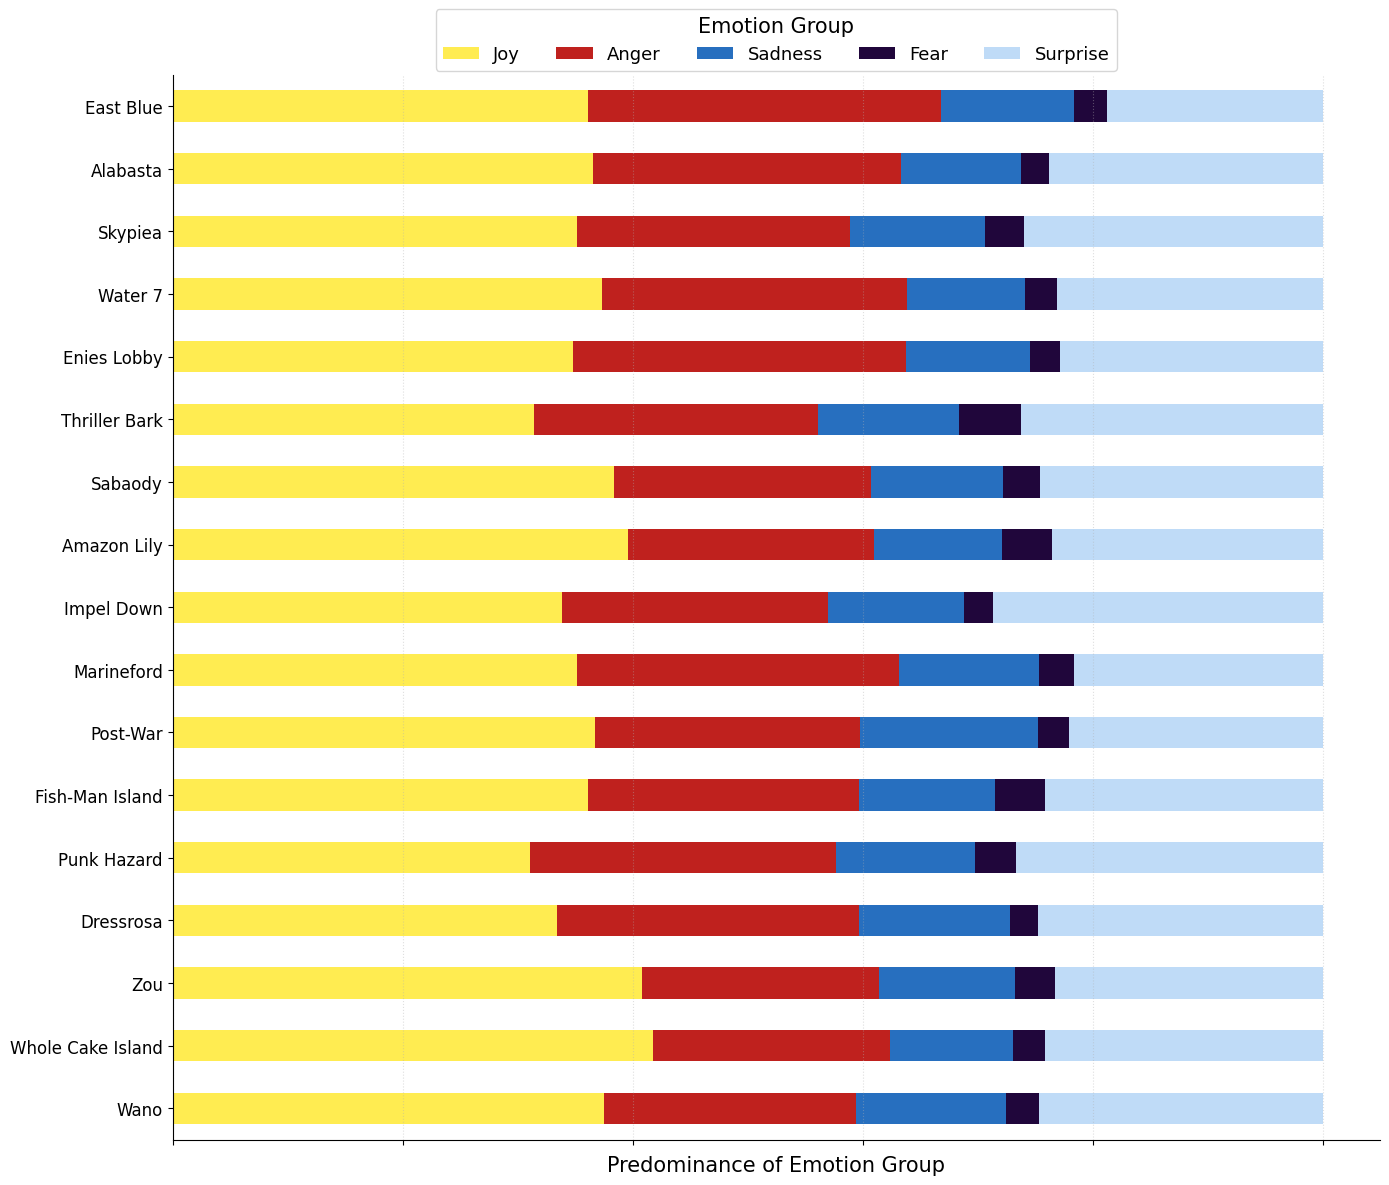

In [11]:
# Pivot table for the stacked bar plot
pivot_df = grouped_emotions.pivot_table(
    index="saga", 
    columns="emotion_group", 
    values="proportion", 
    fill_value=0
)

# Custom color palette for emotion groups
emotion_colors = {
    "Joy": "#FFEC51",
    "Anger": "#BF211E",
    "Sadness": "#276FBF",
    "Fear": "#20063B",
    "Surprise": "#BFDBF7"  
}

saga_order = [
    "East Blue", "Alabasta", "Skypiea", "Water 7", "Enies Lobby",
    "Thriller Bark", "Sabaody", "Amazon Lily", "Impel Down",
    "Marineford", "Post-War", "Fish-Man Island", "Punk Hazard",
    "Dressrosa", "Zou", "Whole Cake Island", "Wano"
][::-1]

# 2. Reindex pivot_df to reflect saga narrative order
pivot_df = pivot_df.reindex(saga_order)


# Ensure consistent order of columns
pivot_df = pivot_df[[col for col in emotion_colors if col in pivot_df.columns]]

# Plot horizontal stacked bar
ax = pivot_df.plot(
    kind="barh",  # ← horizontal bar chart
    stacked=True,
    figsize=(14, 12),
    color=[emotion_colors[col] for col in pivot_df.columns]
)

# Titles and labels
plt.xlabel("Predominance of Emotion Group", fontsize=15)
plt.ylabel("")
plt.yticks(fontsize=12)

# Legend
plt.legend(
    title="Emotion Group",
    title_fontsize=15,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.07),
    ncol=len(pivot_df.columns)
)

# Layout and style
plt.tight_layout()
sns.despine()
ax.set_xticklabels([])
plt.grid(axis='x', linestyle='dotted', alpha=0.4)
plt.show()

**Note:** Notice how difficult is to compare the inner emotion groups. This happens because the stacked bar visual is not used for comparison and is only a way of looking to each saga individually. To compare them, we must use filters for each emotion group and order by the % predominance of that group. Let's do it now.

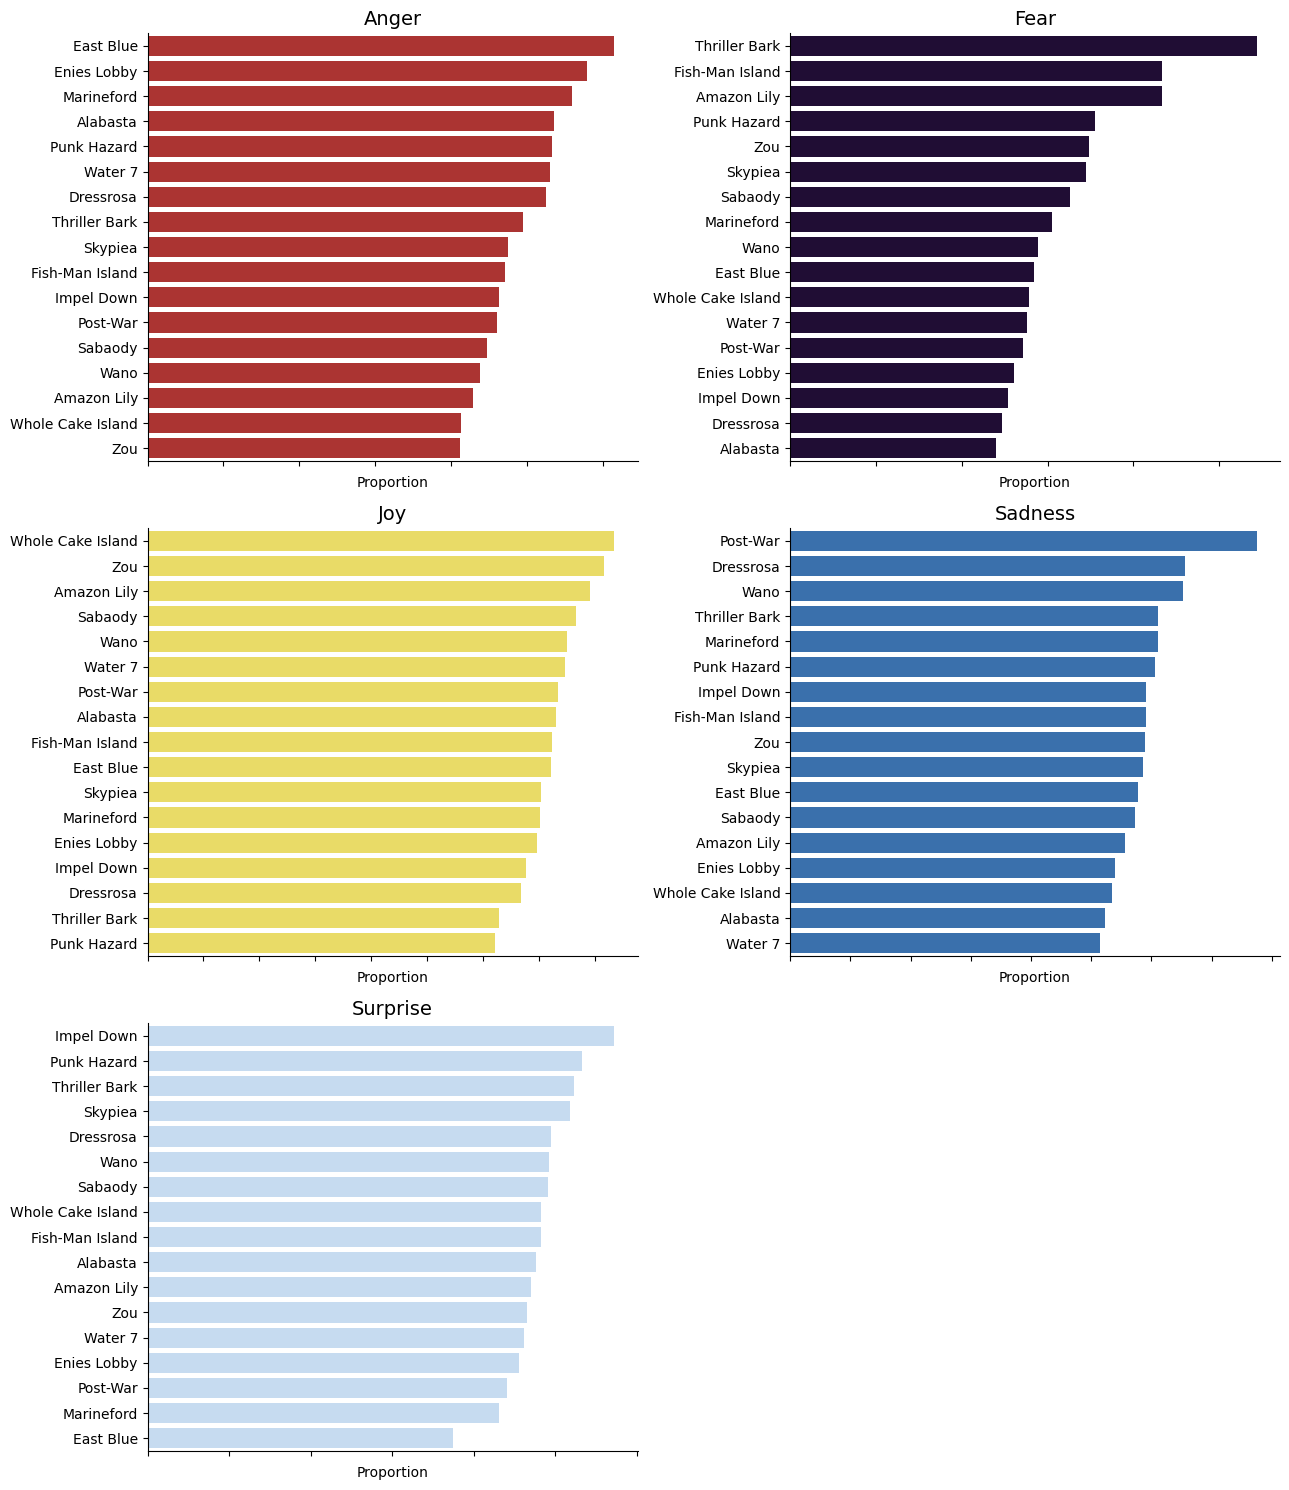

In [12]:
# 1. Melt the pivot_df to long format
melted_df = pivot_df.reset_index().melt(
    id_vars="saga",
    var_name="emotion_group",
    value_name="proportion"
)

# 2. Sort sagas by emotion-specific descending proportion
melted_df["saga_ordered"] = melted_df.groupby("emotion_group")["proportion"] \
    .transform(lambda x: pd.Series(x).rank(ascending=False, method='first'))

# 3. Define the color mapping (same as you already use)
emotion_colors = {
    "Joy": "#FFEC51",
    "Anger": "#BF211E",
    "Sadness": "#276FBF",
    "Fear": "#20063B",
    "Surprise": "#BFDBF7"
}

# 4. Create the FacetGrid
g = sns.FacetGrid(
    data=melted_df,
    col="emotion_group",
    sharex=False,
    sharey=False,
    col_wrap=2,
    height=5,
    aspect=1.3
)

# 5. Plot each facet with the color tied to its emotion
for ax, (emotion, subdf) in zip(g.axes.flat, melted_df.groupby("emotion_group")):
    # Order sagas for this emotion only
    ordered_sagas = subdf.sort_values("proportion", ascending=False)["saga"]

    sns.barplot(
        data=subdf,
        y="saga",
        x="proportion",
        order=ordered_sagas,
        color=emotion_colors[emotion],
        ax=ax
    )

    ax.set_title(emotion, fontsize=14)
    ax.set_xlabel("Proportion")
    ax.set_ylabel("")

    # Optional: adjust font size
    ax.set_xticklabels([])

# Layout and style
plt.tight_layout()
plt.show()

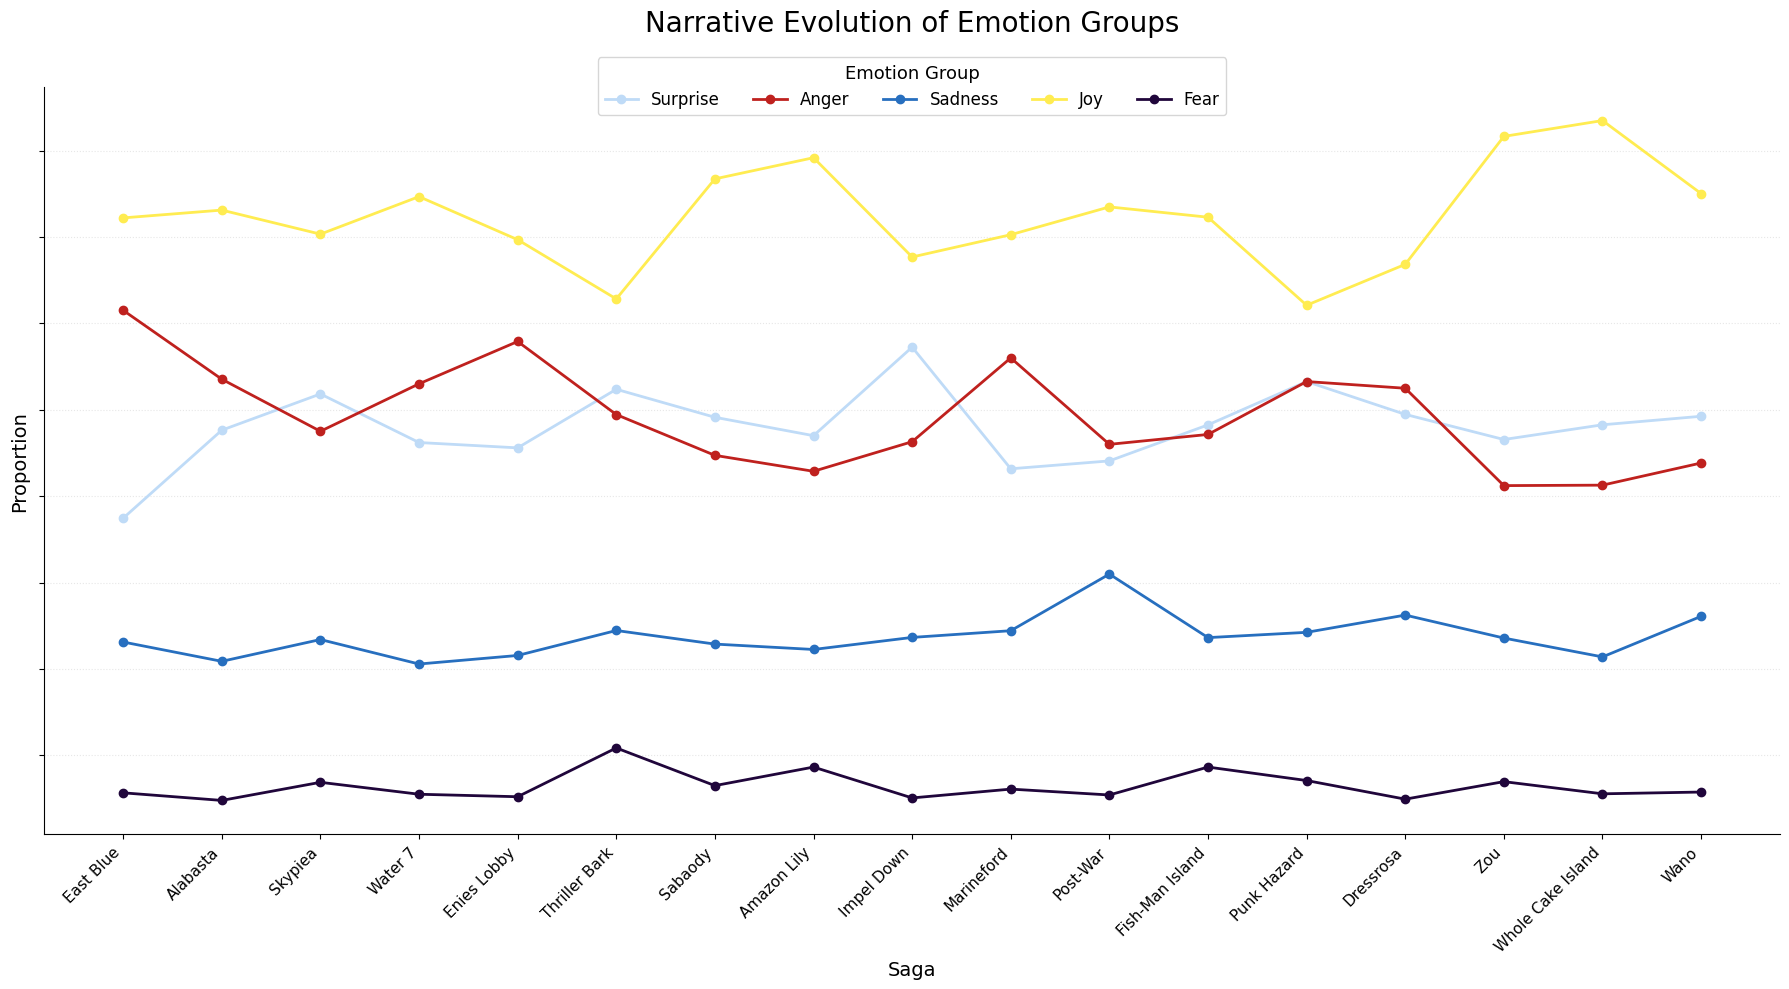

In [13]:
# Make sure 'saga' is a categorical column with defined order
melted_df["saga"] = pd.Categorical(melted_df["saga"], categories=saga_order[::-1], ordered=True)
melted_df = melted_df.sort_values("saga")

# Plotting
plt.figure(figsize=(18, 10))

for emotion in melted_df["emotion_group"].unique():
    df_emotion = melted_df[melted_df["emotion_group"] == emotion]
    plt.plot(
        df_emotion["saga"],
        df_emotion["proportion"],
        label=emotion,
        color=emotion_colors.get(emotion, "gray"),
        linewidth=2,
        marker="o"
    )

# Aesthetics
plt.title("Narrative Evolution of Emotion Groups", fontsize=20, pad=40)
plt.ylabel("Proportion", fontsize=14)
plt.xlabel("Saga", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=11)

plt.legend(
    title="Emotion Group", 
    fontsize=12, 
    title_fontsize=13,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(melted_df["emotion_group"].unique())
)
plt.grid(axis='y', linestyle='dotted', alpha=0.3)
plt.gca().set_yticklabels([])
plt.tight_layout()
sns.despine()

plt.show()


I think that this is already looking great for our analysis on the sagas level. Now let's see it on the character level!

# Text Analysis of Emotions by Character

As documented on the readme file, this may not work so well, as the character detection of the magiv2 transformer is a bit off most of the times. Either way, let's have a looksie!

In [14]:
onepiecedata = pd.read_parquet("../outputs/character.parquet")
onepiecedata

,character,text
0,Ace,of the seven warlords of the sea. wont tell. w...
1,Aokiji,stillts. the names tonjit. it was you fellas w...
2,Arlong,is the maximum you can hold you have no chance...
3,Bege,its a credit to them that they survived . in a...
4,Big Mom,life. i turn you into a candyman and lick you ...
...,...,...
67,Whitebeard,looks like. i thought we were gonna fall onto ...
68,Yamato,way to drop your name like a man. there is onl...
69,Zeff,if some thing tastes bad im gonna say so. ha y...
70,Zoro,where do you get that power. he knocked me thr...


I'll use all functions from before, so this part is quite simple:

In [15]:
# onepiecedata["emotions"] = onepiecedata["text"].apply(lambda x: classify_emotions(x.split(".")))
# onepiecedata.to_parquet("../outputs/emotions_by_character.parquet")

In [16]:
onepiecedata = pd.read_parquet("../outputs/emotions_by_character.parquet")
onepiecedata.head()

,character,text,emotions
0,Ace,of the seven warlords of the sea. wont tell. w...,"{'admiration': 26.0, 'amusement': 12.0, 'anger..."
1,Aokiji,stillts. the names tonjit. it was you fellas w...,"{'admiration': 3.0, 'amusement': 1.0, 'anger':..."
2,Arlong,is the maximum you can hold you have no chance...,"{'admiration': 24.0, 'amusement': 18.0, 'anger..."
3,Bege,its a credit to them that they survived . in a...,"{'admiration': 33.0, 'amusement': 15.0, 'anger..."
4,Big Mom,life. i turn you into a candyman and lick you ...,"{'admiration': 67.0, 'amusement': 40.0, 'anger..."


Now that I think of it, I don't wish to expand this analysis to more than the straw hat crew. I could have saved some time on this process by filtering them before...

Well, let's do it now.

In [17]:
characters = ["Luffy", "Zoro", "Nami", "Usopp", "Sanji", "Chopper", "Robin", "Franky", "Brook", "Jinbe"]

onepiecedata = onepiecedata[onepiecedata["character"].isin(characters)]
onepiecedata

,character,text,emotions
7,Brook,right now shoot me straight into that things s...,"{'admiration': 105.0, 'amusement': 43.0, 'ange..."
11,Chopper,who goes there on yon beach ninnin. rolling ex...,"{'admiration': 173.0, 'amusement': 105.0, 'ang..."
17,Franky,heh heh heh. toms workers. you guys look more ...,"{'admiration': 122.0, 'amusement': 80.0, 'ange..."
31,Jinbe,let me handle this. inside wada tsumis mouth. ...,"{'admiration': 132.0, 'amusement': 96.0, 'ange..."
40,Luffy,why dont you do it youra self. make your selve...,"{'admiration': 296.0, 'amusement': 123.0, 'ang..."
44,Nami,stop it every one. i suppose leaving things in...,"{'admiration': 259.0, 'amusement': 114.0, 'ang..."
57,Robin,are you going to toss me into the sea first. o...,"{'admiration': 118.0, 'amusement': 59.0, 'ange..."
59,Sanji,ssomething fell from above. then let the cooki...,"{'admiration': 201.0, 'amusement': 80.0, 'ange..."
65,Usopp,oars. no no no no of course not im not the cap...,"{'admiration': 220.0, 'amusement': 118.0, 'ang..."
70,Zoro,where do you get that power. he knocked me thr...,"{'admiration': 101.0, 'amusement': 46.0, 'ange..."


In [18]:
emotion_expanded = []
for idx, row in onepiecedata.iterrows():
    for emotion, count in row["emotions"].items():
        emotion_expanded.append({
            "character": row["character"],
            "emotion": emotion,
            "count": count
        })

emotions_df = emotions_df[emotions_df["emotion"] != "neutral"]
emotions_df = pd.DataFrame(emotion_expanded).fillna(0)
emotions_df

,character,emotion,count
0,Brook,admiration,105.0
1,Brook,amusement,43.0
2,Brook,anger,55.0
3,Brook,annoyance,56.0
4,Brook,approval,92.0
...,...,...,...
265,Zoro,realization,25.0
266,Zoro,relief,0.0
267,Zoro,remorse,25.0
268,Zoro,sadness,90.0


In [19]:
# Add a new column with grouped emotion labels
emotions_df["emotion_group"] = emotions_df["emotion"].map(emotion_groups)

# Group by character and emotion group, summing the counts
grouped_emotions = (
    emotions_df.groupby(["character", "emotion_group"])["count"]
    .sum()
    .reset_index()
)

# Calculate total emotion counts per character
total_per_saga = grouped_emotions.groupby("character")["count"].sum().rename("total")

# Merge totals back and compute proportional share
grouped_emotions = grouped_emotions.merge(total_per_saga, on="character")
grouped_emotions["proportion"] = grouped_emotions["count"] / grouped_emotions["total"]
grouped_emotions

,character,emotion_group,count,total,proportion
0,Brook,Anger,204.0,3246.0,0.062847
1,Brook,Fear,34.0,3246.0,0.010474
2,Brook,Joy,325.0,3246.0,0.100123
3,Brook,Sadness,94.0,3246.0,0.028959
4,Brook,Surprise,2589.0,3246.0,0.797597
5,Chopper,Anger,369.0,6151.0,0.059990
6,Chopper,Fear,58.0,6151.0,0.009429
7,Chopper,Joy,596.0,6151.0,0.096895
8,Chopper,Sadness,174.0,6151.0,0.028288
9,Chopper,Surprise,4954.0,6151.0,0.805397


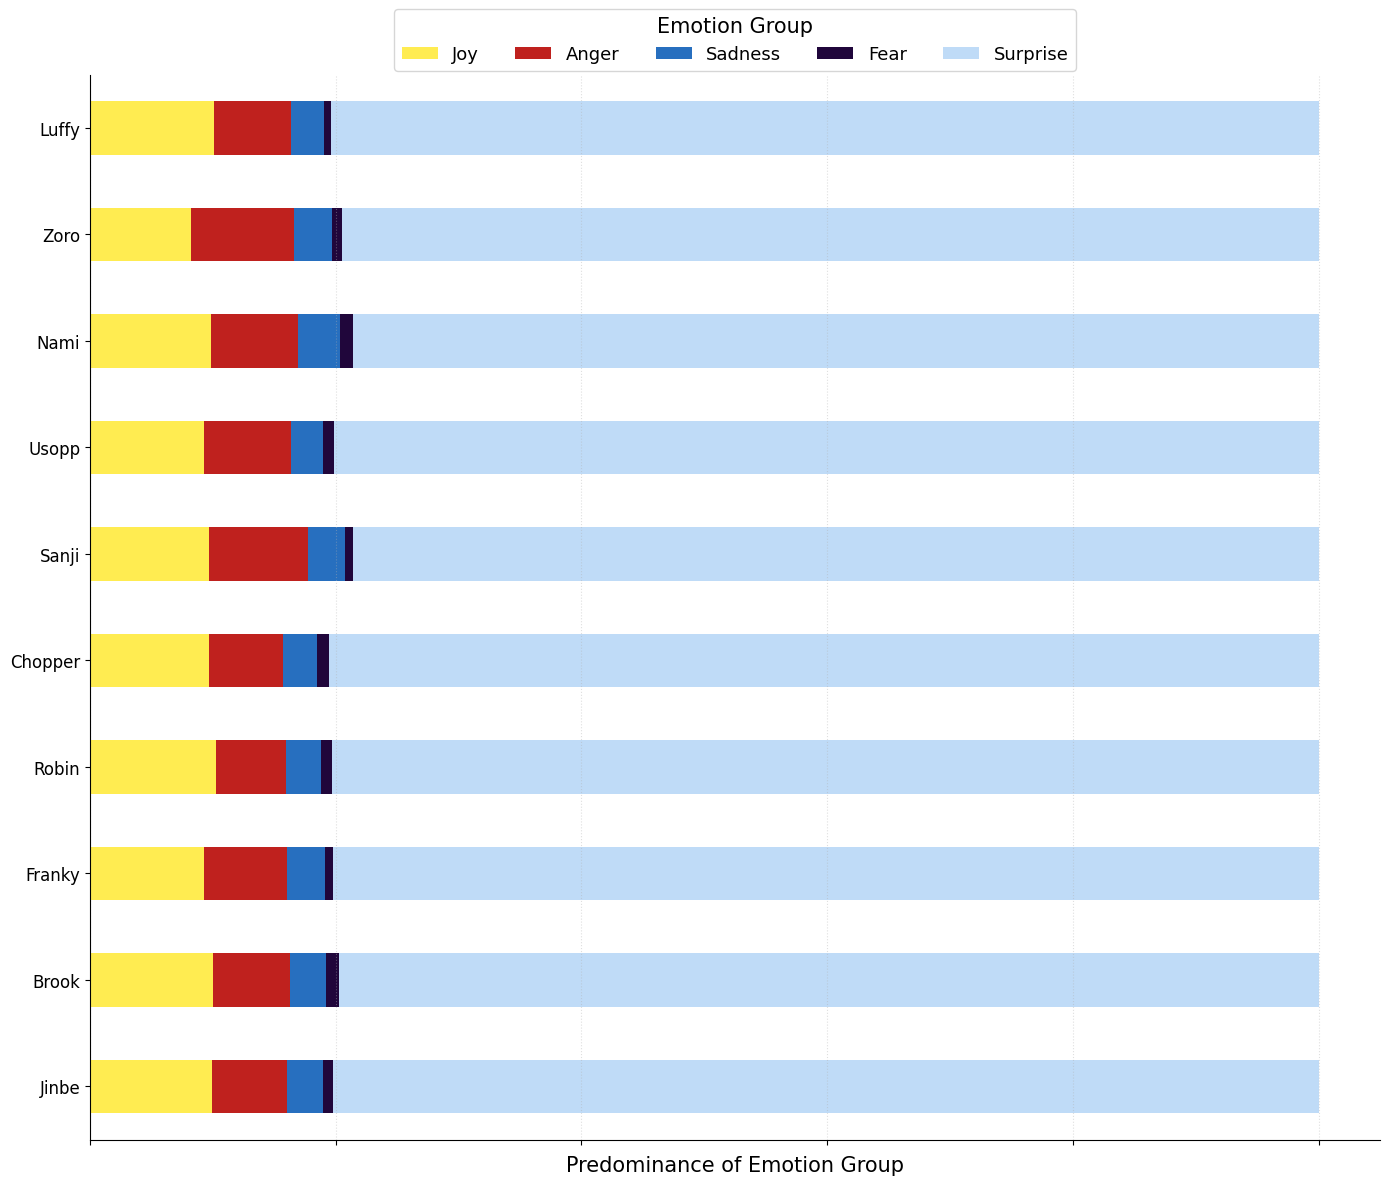

In [20]:
# Pivot table for the stacked bar plot
pivot_df = grouped_emotions.pivot_table(
    index="character", 
    columns="emotion_group", 
    values="proportion", 
    fill_value=0
)

# 2. Reindex pivot_df to reflect saga narrative order
pivot_df = pivot_df.reindex(characters[::-1])

# Ensure consistent order of columns
pivot_df = pivot_df[[col for col in emotion_colors if col in pivot_df.columns]]

# Plot horizontal stacked bar
ax = pivot_df.plot(
    kind="barh",  # ← horizontal bar chart
    stacked=True,
    figsize=(14, 12),
    color=[emotion_colors[col] for col in pivot_df.columns]
)

# Titles and labels
plt.xlabel("Predominance of Emotion Group", fontsize=15)
plt.ylabel("")
plt.yticks(fontsize=12)

# Legend
plt.legend(
    title="Emotion Group",
    title_fontsize=15,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.07),
    ncol=len(pivot_df.columns)
)

# Layout and style
plt.tight_layout()
sns.despine()
ax.set_xticklabels([])
plt.grid(axis='x', linestyle='dotted', alpha=0.4)
plt.show()

Well, that is a bummer :<

You may think: "why is that"

By looking at how emotions are distributed on that visual, for each strawhat, there is not much we could say about their phrases on the narrative. Maybe due to wrong classifications during transcription or due to technicalities on the narrative so far. I was hoping to be able to differentiate them based on emotions, as I have a bias on believing Luffy would be the most joyful of them all. It sure looks like that, but statistically I don't think we could make this affirmation.

Out of curiosity I remade this visual to each character on the analysis and nothing stood out. I gues that's it for characters then.

If you liked my project so far and wish to contribute in any way or suggest me something to try, feel free to reach me out on linkedin! I don't have anything else planned for this as of the time I'm writing my last analysis.

I'll be posting pdfs I've made for linkedin in the english language, exploring everything I've done so far and they will also be available on this repo. 

If you read everything through, `congrats!` For me (as I kept you here somehow) and to you for you curiosity! Until a next time!